<a href="https://colab.research.google.com/github/DL4CV-NPTEL/Deep-Learning-For-Computer-Vision/blob/main/notebooks/Week_4/Week_4_Lecture_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lecture 7: Regularization in Neural Networks Part 1 <sup><mark style="background-color:gold">Code</mark> </sup>

In [5]:
#@title 
from ipywidgets import widgets
out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"fS1aoHtTKMs", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)
display(out1)

Output()

In [6]:
#@title 
from IPython import display as IPyDisplay
IPyDisplay.HTML(
    f"""
  <div>
    <a href= "https://github.com/DL4CV-NPTEL/Deep-Learning-For-Computer-Vision/blob/main/Slides/Week_4/DL4CV_Week04_Part04.pdf" target="_blank">
    <img src="https://github.com/DL4CV-NPTEL/Deep-Learning-For-Computer-Vision/blob/main/Data/Slides_Logo.png?raw=1"
  alt="button link to Airtable" style="width:200px"></a>
    </div>""" )

## Logistic Regression with L2 Regularization

**Imports**

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn.functional as F

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
LAMBDA = 2

**Preparing a toy dataset**

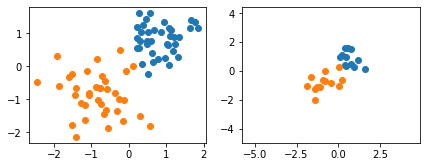

In [8]:
##########################
### DATASET
##########################

data = np.genfromtxt('https://raw.githubusercontent.com/DL4CV-NPTEL/Deep-Learning-For-Computer-Vision/main/Data/Week%204/toydata.txt', delimiter='\t')
x = data[:, :2].astype(np.float32)
y = data[:, 2].astype(np.int64)

np.random.seed(123)
idx = np.arange(y.shape[0])
np.random.shuffle(idx)
X_test, y_test = x[idx[:25]], y[idx[:25]]
X_train, y_train = x[idx[25:]], y[idx[25:]]
mu, std = np.mean(X_train, axis=0), np.std(X_train, axis=0)
X_train, X_test = (X_train - mu) / std, (X_test - mu) / std

fig, ax = plt.subplots(1, 2, figsize=(7, 2.5))
ax[0].scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1])
ax[0].scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1])
ax[1].scatter(X_test[y_test == 1, 0], X_test[y_test == 1, 1])
ax[1].scatter(X_test[y_test == 0, 0], X_test[y_test == 0, 1])
plt.xlim([x[:, 0].min()-0.5, x[:, 0].max()+0.5])
plt.ylim([x[:, 1].min()-0.5, x[:, 1].max()+0.5])
plt.show()

### L2-Regularized Logistic Regression via weight_decay

In [9]:
def custom_where(cond, x_1, x_2):
    return (cond * x_1) + ((1-cond) * x_2)


class LogisticRegression(torch.nn.Module):

    def __init__(self, num_features):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(num_features, 1)
        # initialize weights to zeros here,
        # since we used zero weights in the
        # manual approach
        
        self.linear.weight.detach().zero_()
        self.linear.bias.detach().zero_()
        # Note: the trailing underscore
        # means "in-place operation" in the context
        # of PyTorch
        
    def forward(self, x):
        logits = self.linear(x)
        probas = torch.sigmoid(logits)
        return probas

model = LogisticRegression(num_features=2).to(device)

#########################################################
## Apply L2 regularization
optimizer = torch.optim.SGD(model.parameters(), 
                            lr=0.1, 
                            weight_decay=LAMBDA)
#-------------------------------------------------------


def comp_accuracy(label_var, pred_probas):
    pred_labels = custom_where((pred_probas > 0.5).float(), 1, 0).view(-1)
    acc = torch.sum(pred_labels == label_var.view(-1)).float() / label_var.size(0)
    return acc


num_epochs = 30

X_train_tensor = torch.tensor(X_train, dtype=torch.float32, device=device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32, device=device).view(-1, 1)


for epoch in range(num_epochs):
    
    #### Compute outputs ####
    out = model(X_train_tensor)
    
    #### Compute gradients ####
    cost = F.binary_cross_entropy(out, y_train_tensor, reduction='sum')
    optimizer.zero_grad()
    cost.backward()
    
    #### Update weights ####  
    optimizer.step()
    
    #### Logging ####      
    pred_probas = model(X_train_tensor)
    acc = comp_accuracy(y_train_tensor, pred_probas)
    print('Epoch: %03d' % (epoch + 1), end="")
    print(' | Train ACC: %.3f' % acc, end="")
    print(' | Cost: %.3f' % F.binary_cross_entropy(pred_probas, y_train_tensor))


    
print('\nModel parameters:')
print('  Weights: %s' % model.linear.weight)
print('  Bias: %s' % model.linear.bias)


X_test_tensor = torch.tensor(X_test, dtype=torch.float32, device=device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32, device=device)

pred_probas = model(X_test_tensor)
test_acc = comp_accuracy(y_test_tensor, pred_probas)

print('\n\nTest set accuracy: %.2f%%' % (test_acc*100))

Epoch: 001 | Train ACC: 0.973 | Cost: 0.055
Epoch: 002 | Train ACC: 0.973 | Cost: 0.065
Epoch: 003 | Train ACC: 0.973 | Cost: 0.080
Epoch: 004 | Train ACC: 0.973 | Cost: 0.094
Epoch: 005 | Train ACC: 0.973 | Cost: 0.104
Epoch: 006 | Train ACC: 0.973 | Cost: 0.108
Epoch: 007 | Train ACC: 0.973 | Cost: 0.110
Epoch: 008 | Train ACC: 0.973 | Cost: 0.111
Epoch: 009 | Train ACC: 0.973 | Cost: 0.112
Epoch: 010 | Train ACC: 0.973 | Cost: 0.112
Epoch: 011 | Train ACC: 0.973 | Cost: 0.112
Epoch: 012 | Train ACC: 0.973 | Cost: 0.112
Epoch: 013 | Train ACC: 0.973 | Cost: 0.112
Epoch: 014 | Train ACC: 0.973 | Cost: 0.112
Epoch: 015 | Train ACC: 0.973 | Cost: 0.112
Epoch: 016 | Train ACC: 0.973 | Cost: 0.112
Epoch: 017 | Train ACC: 0.973 | Cost: 0.112
Epoch: 018 | Train ACC: 0.973 | Cost: 0.112
Epoch: 019 | Train ACC: 0.973 | Cost: 0.112
Epoch: 020 | Train ACC: 0.973 | Cost: 0.112
Epoch: 021 | Train ACC: 0.973 | Cost: 0.112
Epoch: 022 | Train ACC: 0.973 | Cost: 0.112
Epoch: 023 | Train ACC: 0.973 | 

### L2-Regularized Logistic Regression via Manual Regularization

In [10]:
model = LogisticRegression(num_features=2).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

for epoch in range(num_epochs):
    
    #### Compute outputs ####
    out = model(X_train_tensor)
    
    #### Compute gradients ####
    
    #########################################################
    ## Apply L2 regularization (weight decay)
    cost = F.binary_cross_entropy(out, y_train_tensor, reduction='sum')
    cost = cost + 0.5 * LAMBDA * torch.mm(model.linear.weight,
                                          model.linear.weight.t())
    
    # note that PyTorch also regularizes the bias, hence, if we want
    # to reproduce the behavior of SGD's "weight_decay" param, we have to add
    # the bias term as well: 
    cost = cost + 0.5 * LAMBDA * model.linear.bias**2
    #-------------------------------------------------------
    
    optimizer.zero_grad()
    cost.backward()
    
    #### Update weights ####  
    optimizer.step()
    
    #### Logging ####      
    pred_probas = model(X_train_tensor)
    acc = comp_accuracy(y_train_tensor, pred_probas)
    print('Epoch: %03d' % (epoch + 1), end="")
    print(' | Train ACC: %.3f' % acc, end="")
    print(' | Cost: %.3f' % F.binary_cross_entropy(pred_probas, y_train_tensor))


    
print('\nModel parameters:')
print('  Weights: %s' % model.linear.weight)
print('  Bias: %s' % model.linear.bias)


X_test_tensor = torch.tensor(X_test, dtype=torch.float32, device=device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32, device=device)

pred_probas = model(X_test_tensor)
test_acc = comp_accuracy(y_test_tensor, pred_probas)

print('\n\nTest set accuracy: %.2f%%' % (test_acc*100))

Epoch: 001 | Train ACC: 0.973 | Cost: 0.055
Epoch: 002 | Train ACC: 0.973 | Cost: 0.065
Epoch: 003 | Train ACC: 0.973 | Cost: 0.080
Epoch: 004 | Train ACC: 0.973 | Cost: 0.094
Epoch: 005 | Train ACC: 0.973 | Cost: 0.104
Epoch: 006 | Train ACC: 0.973 | Cost: 0.108
Epoch: 007 | Train ACC: 0.973 | Cost: 0.110
Epoch: 008 | Train ACC: 0.973 | Cost: 0.111
Epoch: 009 | Train ACC: 0.973 | Cost: 0.112
Epoch: 010 | Train ACC: 0.973 | Cost: 0.112
Epoch: 011 | Train ACC: 0.973 | Cost: 0.112
Epoch: 012 | Train ACC: 0.973 | Cost: 0.112
Epoch: 013 | Train ACC: 0.973 | Cost: 0.112
Epoch: 014 | Train ACC: 0.973 | Cost: 0.112
Epoch: 015 | Train ACC: 0.973 | Cost: 0.112
Epoch: 016 | Train ACC: 0.973 | Cost: 0.112
Epoch: 017 | Train ACC: 0.973 | Cost: 0.112
Epoch: 018 | Train ACC: 0.973 | Cost: 0.112
Epoch: 019 | Train ACC: 0.973 | Cost: 0.112
Epoch: 020 | Train ACC: 0.973 | Cost: 0.112
Epoch: 021 | Train ACC: 0.973 | Cost: 0.112
Epoch: 022 | Train ACC: 0.973 | Cost: 0.112
Epoch: 023 | Train ACC: 0.973 | 

**Acknowledgements**

Code adopted from the excellent lectures of Sebastian Raschka

https://sebastianraschka.com/blog/2021/dl-course.html